In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [2]:
# Random seed for reproducibility
seed = 16

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
dataset_path = os.path.join('../input/anndlhw2/Training.csv')

In [4]:
X = np.genfromtxt('../input/anndlhw2/Training.csv',delimiter=',',skip_header=True)

In [5]:
# Pre-processing

X_max = X.max(axis=0)
X_min = X.min(axis=0)

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

X_scaled = (X-X_min)/(X_max-X_min)

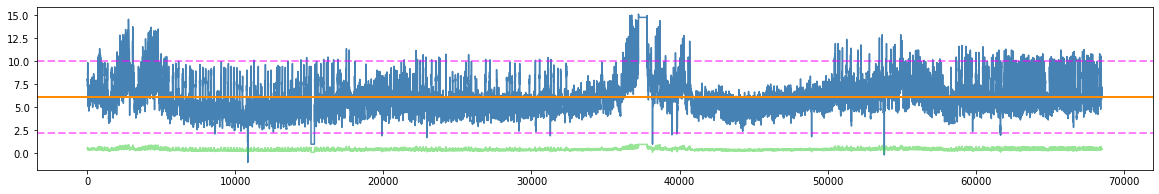

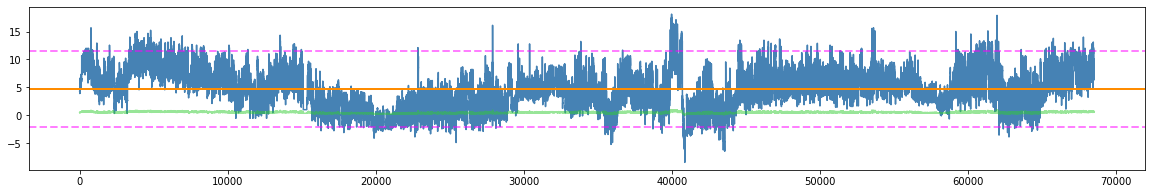

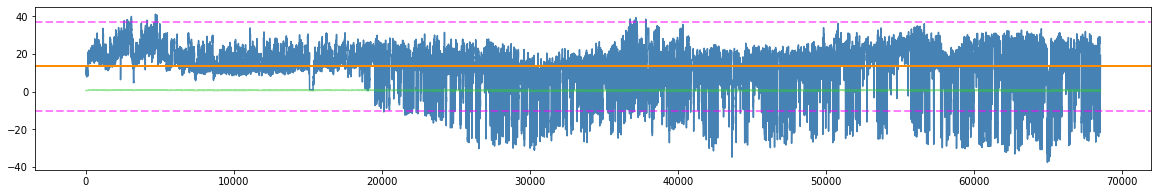

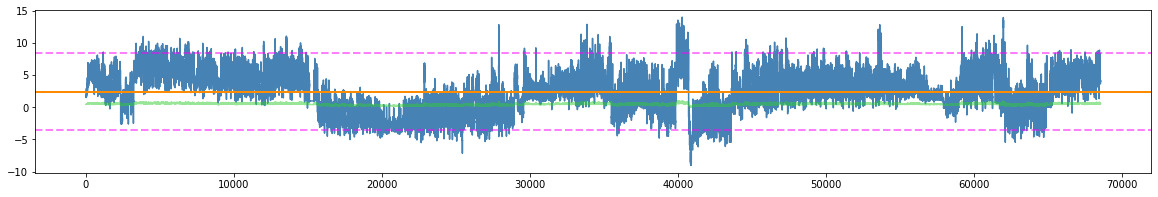

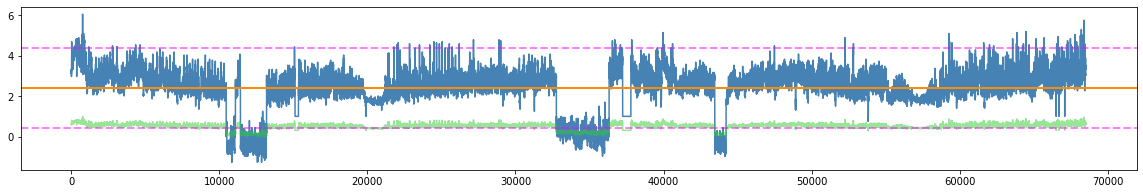

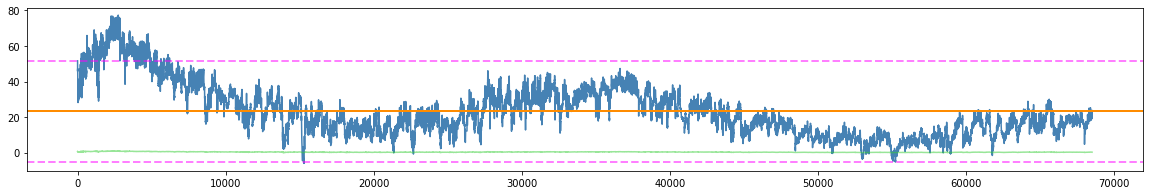

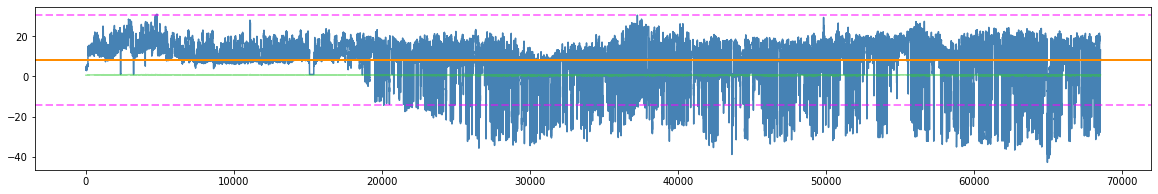

In [6]:
for i in range(X.shape[-1]):
    plt.figure(figsize=(20,3))
    plt.plot(X[:,i],color='steelblue')
    plt.plot(X_scaled[:,i],color='limegreen',alpha=.5)
    plt.axhline(y=X_mean[i],color='darkorange',linewidth=2)
    plt.axhline(y=X_mean[i]+2*X_std[i],color='magenta',alpha=.5,linestyle='--',linewidth=2)
    plt.axhline(y=X_mean[i]-2*X_std[i],color='magenta',alpha=.5,linestyle='--',linewidth=2)

In [7]:
# generate X, y
def extract_sequences(array,sequence_length = 200,stride=1,shuffle=True,seed=1):
   
    X = []
    y = []
    for i in range(0,len(array),stride):
        if i+sequence_length < len(array):
            X.append(array[i:i+sequence_length])
            y.append(array[i+sequence_length])
    X = np.array(X)
    y = np.array(y)
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(X)
        np.random.seed(seed)
        np.random.shuffle(y)
    return X, y

In [8]:
sequence_length = 300
stride = 1
X_train, y_train = extract_sequences(X_scaled,sequence_length,stride)

In [9]:
input_shape = X_train.shape[1:]
epochs = 200
batch_size = 256

In [10]:
def build_conv_lstm_state(input_shape):

    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
   
    x,h,c = tfkl.LSTM(256, return_sequences=True,return_state=True)(x)
    x = tfkl.Conv1D(filters=32,kernel_size=3,strides=1,padding="same")(input_layer)
    x = tfkl.AveragePooling1D()(x)
    
    x = tfkl.Conv1D(filters=64,kernel_size=3,strides=1,padding="same")(x)
    x = tfkl.AveragePooling1D()(x)
    x,h,c = tfkl.LSTM(256, return_sequences=True,return_state=True)(x,initial_state=[h,c])
    x = tfkl.LayerNormalization()(x)
    
    x = tfkl.Conv1D(filters=128,kernel_size=3,strides=1,padding="same")(x)
    x = tfkl.AveragePooling1D()(x)
    x = tfkl.LSTM(256, return_sequences=False)(x,initial_state=[h,c])
    x = tfkl.LayerNormalization()(x)
    
    x = tfkl.Dense(64,activation='relu')(x)
    x = tfkl.Dropout(.2)(x)
    output_layer = tfkl.Dense(7)(x)
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model

In [11]:
def build_conv_lstm(input_shape):

    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    x = tfkl.Conv1D(filters=16,kernel_size=3,strides=1,padding="same",activation='relu')(input_layer)
    x = tfkl.Conv1D(filters=16,kernel_size=3,strides=1,padding="same")(x)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Conv1D(filters=32,kernel_size=3,strides=1,padding="same",activation='relu')(x)
    x = tfkl.Conv1D(filters=32,kernel_size=3,strides=1,padding="same")(x)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.Conv1D(filters=64,kernel_size=3,strides=1,padding="same",activation='relu')(x)
    x = tfkl.Conv1D(filters=64,kernel_size=3,strides=1,padding="same")(x)
    x = tfkl.MaxPooling1D()(x)
    x = tfkl.LSTM(256, return_sequences=True)(x)
    x = tfkl.LSTM(256, return_sequences=True)(x)
    x = tfkl.LSTM(32, return_sequences=False)(x)
    x = tfkl.LayerNormalization()(x)
    
    x = tfkl.Dense(32,activation='relu')(x)
    x = tfkl.Dropout(.2)(x)
    output_layer = tfkl.Dense(7)(x)
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model

In [12]:
def build_stack_lstm(input_shape):

    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    x = tfkl.LSTM(256, return_sequences=True)(input_layer)
    x = tfkl.LSTM(256, return_sequences=True)(x)
    x = tfkl.LSTM(64, return_sequences=False)(x)
    
    output_layer = tfkl.Dense(7)(x)
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model

# SCORE: 4.098

In [13]:
def build_stack_lstm_bidirectional(input_shape):

    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    x = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(input_layer)
    x = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(x)
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=False))(x)
    
    output_layer = tfkl.Dense(7)(x)
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model

# SCORE: 4.099

In [14]:
def build_lstm_seq2seq(input_shape):

    n_units=512

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x,h,c = tfkl.LSTM(units=n_units, return_sequences=False,return_state=True)(input_layer)
    x = tfkl.RepeatVector(1)(x)
    x = tfkl.LSTM(units=n_units, return_sequences=True,return_state=False)(x,initial_state=[h,c])
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=False,return_state=False))(x)
    x = tfkl.Flatten()(x)
    output_layer = tfkl.Dense(7)(x)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model


In [15]:
def build_gru_seq2seq(input_shape):
    
    n_units = sequence_
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    x,h = tfkl.GRU(units=n_units, return_sequences=False,return_state=True)(input_layer)
    x = tfkl.RepeatVector(1)(x)
    x = tfkl.GRU(units=n_units, return_sequences=True,return_state=False)(x,initial_state=h)
    x = tfkl.Bidirectional(tfkl.GRU(32, return_sequences=False,return_state=False))(x)
    #x = tfkl.Flatten()(x)
    output_layer = tfkl.Dense(7,bias_initializer=tfk.initializers.Constant(X_scaled.mean(axis=0)))(x)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model


In [16]:
def build_lstm_seq2seq_attention(input_shape):

    n_units=256
    
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    encoder_x,encoder_h,encoder_c = tfkl.LSTM(units=n_units, return_sequences=True,return_state=True)(input_layer)
    
    #encoder_h = tfkl.LayerNormalization()(encoder_h)
    #encoder_c = tfkl.LayerNormalization()(encoder_c)
    decoder_in = tfkl.RepeatVector(1)(encoder_h)
    
    decoder_x = tfkl.LSTM(units=n_units, return_sequences=True,return_state=False)(decoder_in,initial_state=[encoder_h,encoder_c])
    
    attention = tfkl.Dot(axes=[2,2])([decoder_x, encoder_x])
    attention = tfkl.Activation('softmax')(attention)
    context = tfkl.Dot(axes=[2,1])([attention,encoder_x])
    #context = tfkl.LayerNormalization()(context)
    
    concatenated_c = tfkl.Concatenate()([context,decoder_x]) 
    concatenated_c = tfkl.Flatten()(concatenated_c)
    output_layer = tfkl.Dense(7, bias_initializer=tfk.initializers.Constant(X_scaled.mean(axis=0)))(concatenated_c)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model


In [19]:
def build_lstm(input_shape,n_units):


    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.LSTM(units=n_units, return_sequences=False,return_state=False)(input_layer)
    x = tfkl.Flatten()(x)
    
    output_layer = tfkl.Dense(7,bias_initializer=tfk.initializers.Constant(X_scaled.mean(axis=0)))(x)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 300, 7)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               1064960   
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 3591      
Total params: 1,068,551
Trainable params: 1,068,551
Non-trainable params: 0
_________________________________________________________________


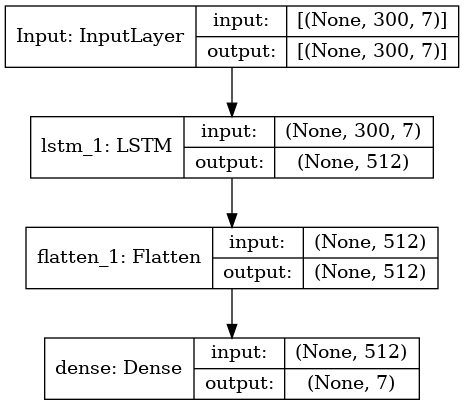

In [20]:
model = build_lstm(input_shape,512)
model.summary()
tfk.utils.plot_model(model, expand_nested=True,show_shapes=True)

In [21]:
model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(1e-3), metrics=['mae'])

history = model.fit(
    X_train,
    y_train,
    validation_split=.1,
    epochs = 200,
    batch_size = 256,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

2022-01-09 08:33:01.931337: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-01-09 08:33:03.938912: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


240/240 [==============================] - 32s 120ms/step - loss: 0.0032 - mae: 0.0373 - val_loss: 0.0013 - val_mae: 0.0247
Epoch 2/200
240/240 [==============================] - 28s 118ms/step - loss: 0.0012 - mae: 0.0234 - val_loss: 0.0011 - val_mae: 0.0226
Epoch 3/200
240/240 [==============================] - 28s 117ms/step - loss: 0.0010 - mae: 0.0212 - val_loss: 9.3222e-04 - val_mae: 0.0199
Epoch 4/200
240/240 [==============================] - 28s 117ms/step - loss: 9.0979e-04 - mae: 0.0197 - val_loss: 8.4873e-04 - val_mae: 0.0187
Epoch 5/200
240/240 [==============================] - 28s 117ms/step - loss: 8.7388e-04 - mae: 0.0191 - val_loss: 8.2473e-04 - val_mae: 0.0182
Epoch 6/200
240/240 [==============================] - 28s 117ms/step - loss: 8.4701e-04 - mae: 0.0186 - val_loss: 8.3470e-04 - val_mae: 0.0183
Epoch 7/200
240/240 [==============================] - 28s 117ms/step - loss: 8.4617e-04 - mae: 0.0186 - val_loss: 8.3674e-04 - val_mae: 0.0187
Epoch 8/200
240/240 [===

In [22]:
window = sequence_length
last_window = X_scaled[-window:]
last_window = np.expand_dims(last_window, axis=0)
pred = model.predict(last_window)
last_window.shape, pred.shape

((1, 300, 7), (1, 7))

In [23]:
future_window = 1152

pred = np.array([])
X_temp = last_window
for t in range(future_window):
    pred_temp = model.predict(X_temp)
    pred_temp = np.expand_dims(pred_temp, axis=0)
    if(len(pred)==0):
        pred = pred_temp
    else:
        pred = np.concatenate((pred,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)

In [24]:
pred_scaled = pred[0]*(X_max-X_min)+X_min

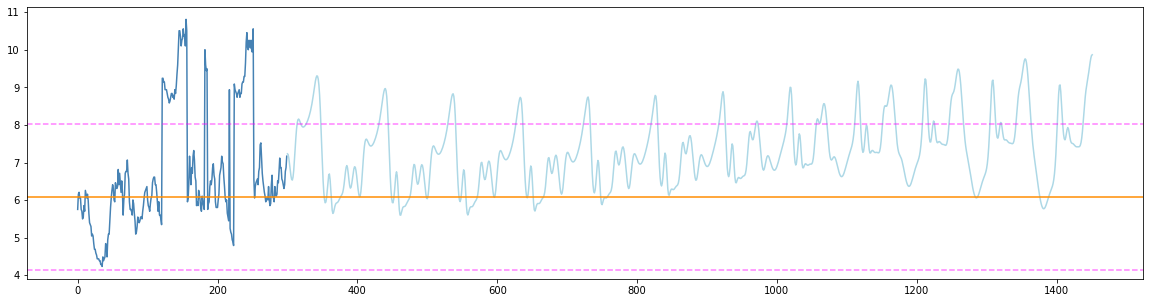

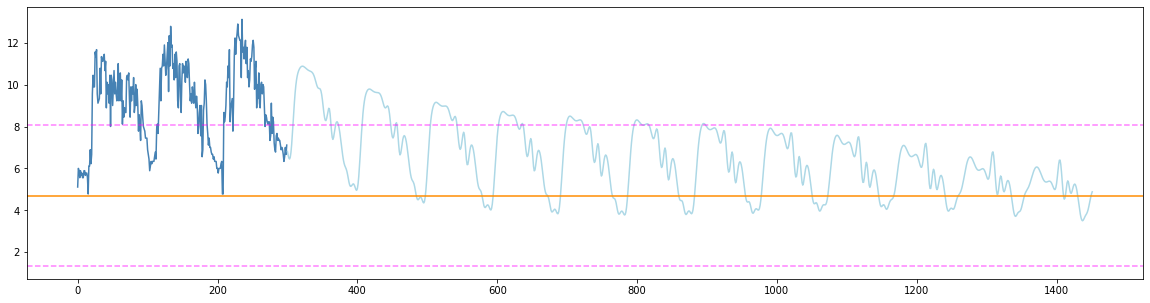

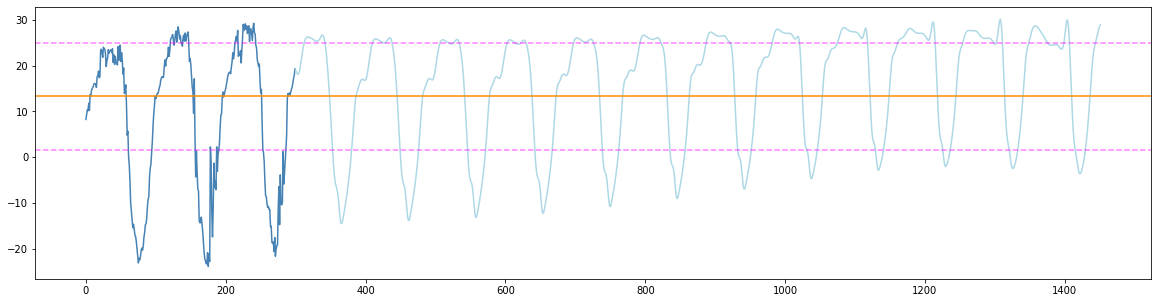

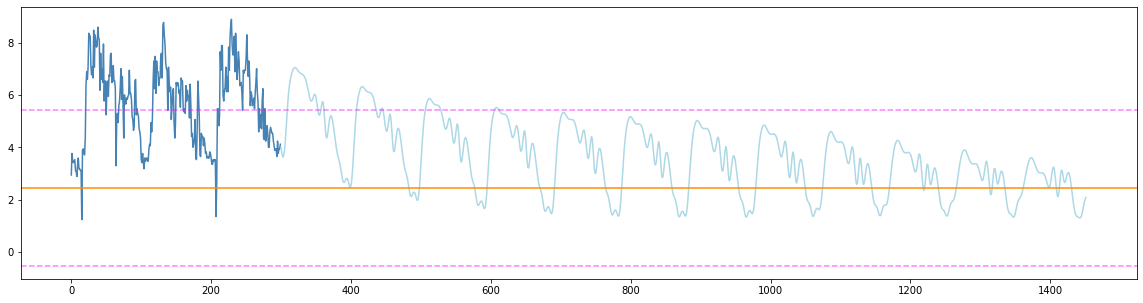

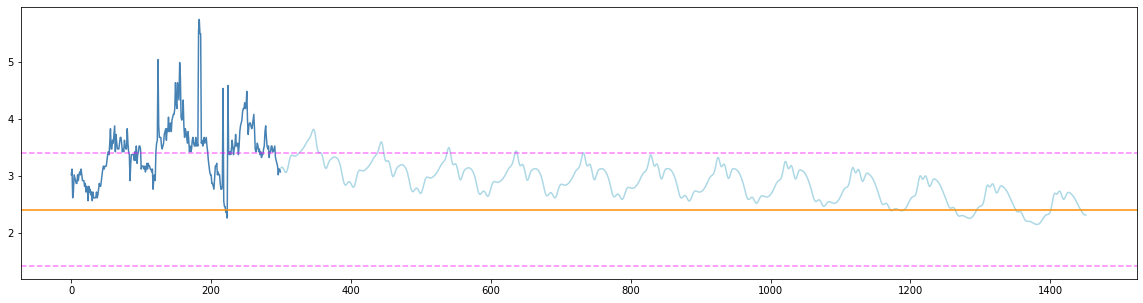

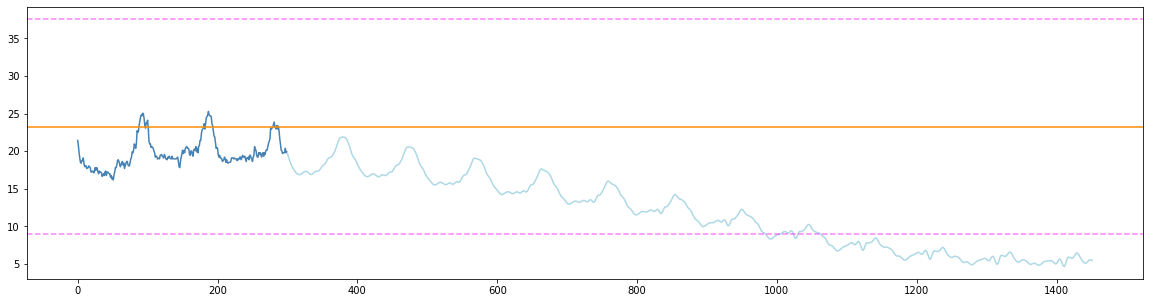

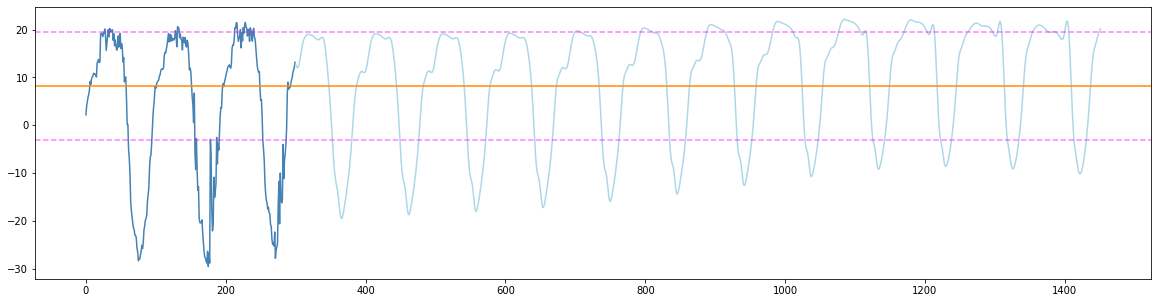

In [25]:
for i in range(pred.shape[-1]):
    plt.figure(figsize=(20,5))
    plt.plot(range(window),X[-window:,i],color='steelblue')
    plt.plot(range(window,window+future_window),pred_scaled[:,i],color='lightblue')
    plt.axhline(y=X_mean[i],color='darkorange',linestyle='-')
    plt.axhline(y=X_mean[i]+X_std[i],color='magenta',linestyle='--',alpha=.5)
    plt.axhline(y=X_mean[i]-X_std[i],color='magenta',linestyle='--',alpha=.5)

In [ ]:
#for i in range(pred_scaled.shape[-1]):
#    plt.figure(figsize=(20,5))
#    plt.plot(range(window),train_scaled[-window:,i])
#    plt.plot(range(window,window+future_window),val_scaled[:future_window,i])
#    plt.plot(range(window,window+future_window),pred[0,:,i])


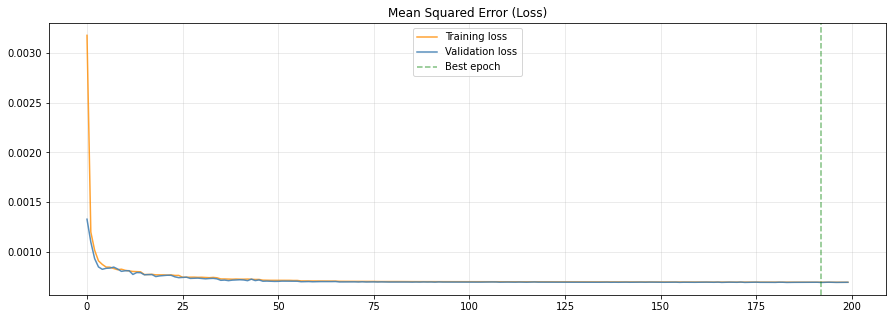

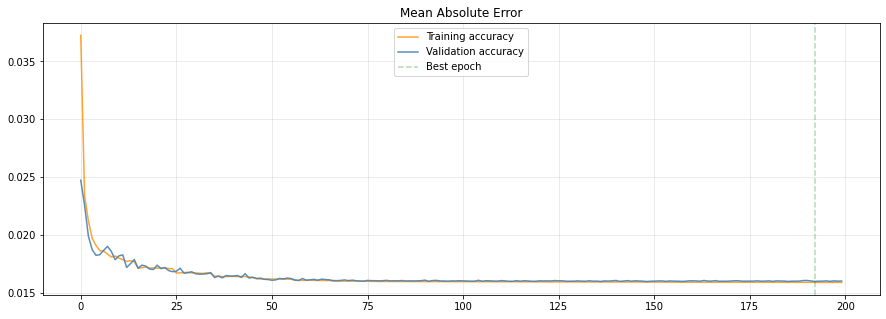

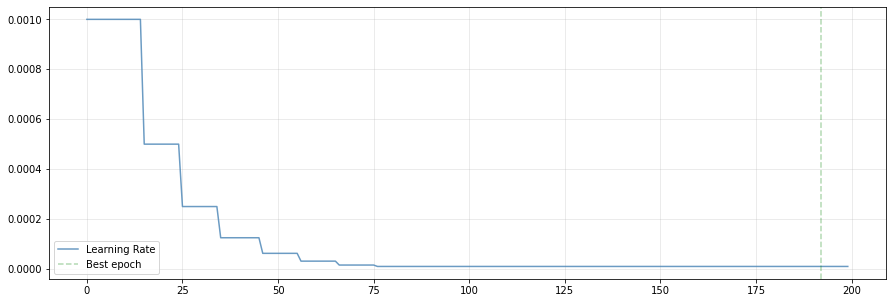

In [26]:
best_epoch = np.argmin(history['val_loss'])
fig_size = (15,5)
plt.figure(figsize=fig_size)
plt.plot(history['loss'], label='Training loss', alpha=.8, color='darkorange')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.5, ls='--', color='green')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=fig_size)
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='darkorange')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='green')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=fig_size)
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='green')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# SCORE 4.0981531143, same with no state and no layer norm

In [27]:
model.save('model')
#model = tfk.models.load_model('model')
!zip -r model.zip model

2022-01-09 10:09:24.684024: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


  adding: model/ (stored 0%)
  adding: model/keras_metadata.pb (deflated 86%)
  adding: model/assets/ (stored 0%)
  adding: model/saved_model.pb (deflated 89%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.index (deflated 59%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 6%)


In [ ]:
#!rm -r model
#!rm -r model.zip